In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.image import imread
import pandas as pd
from pathlib import Path
import cv2
from numpy import array
import sympy as smp
from sklearn.decomposition import PCA
from pysindy import SINDy
from pysindy.differentiation import FiniteDifference
from pysindy.feature_library import PolynomialLibrary
from pysindy.optimizers import STLSQ
from scipy.integrate import odeint

In [2]:
## Load the Mass_Position of each of my carmera with noise
#c1
c1 = np.load('camera1_Noisy.npy')

#c2
c2 = np.load('camera2_Noisy.npy')

#c3
c3 = np.load('camera3_Noisy.npy')

In [7]:
c2.shape

(274, 2)

In [4]:
## reshape all in 225
c1=c2[0:274,:]
c3=c3[0:274,:]

# Concatenate matrices horizontally
C = np.hstack((c1, c2, c3))
C.shape

(274, 6)

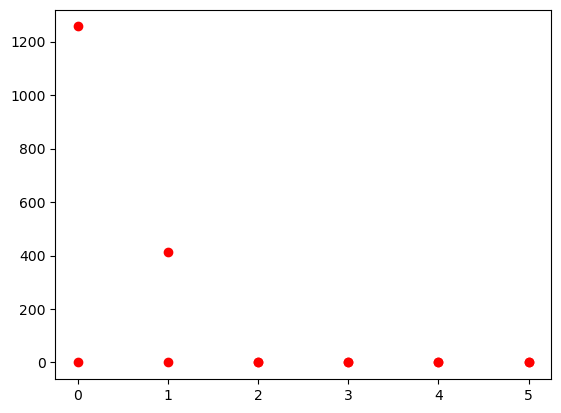

In [5]:
# Subtract the mean of mass_positions_array
B = C - np.mean(C, axis=0)

# Perform singular value decomposition on B
U, s, Vt = np.linalg.svd(B,full_matrices=False)

s=np.diag(s)

plt.plot(s[:,0:2],'ro')
plt.show()

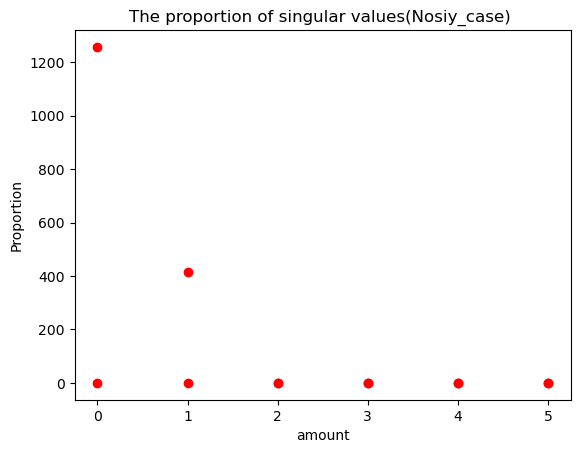

In [75]:
plt.title("The proportion of singular values(Nosiy_case) ")
plt.xlabel('amount')
plt.ylabel('Proportion')
plt.plot(s[:,0:2], 'ro')
plt.show()

In [76]:
s=s[:,0:2]
T = U.dot(s)

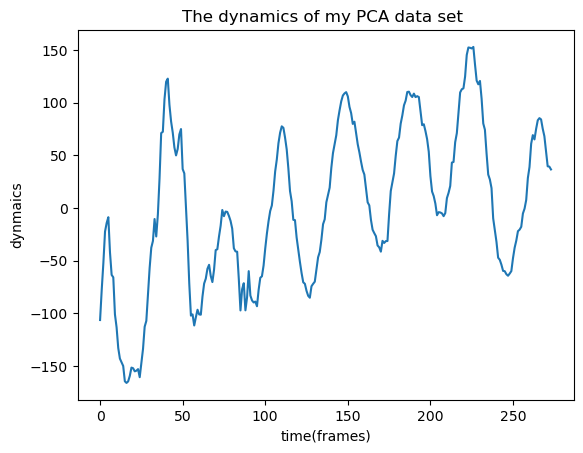

In [78]:
plt.title("The dynamics of my PCA data set ")
plt.xlabel('time(frames)')
plt.ylabel('dynmaics')
plt.plot(T[:,0:1])
plt.show()

In [71]:
# Create a SINDy object with the desired settings
sindy = SINDy(
    differentiation_method=FiniteDifference(),
    feature_library=PolynomialLibrary(degree=4),
    optimizer=STLSQ(threshold=0.01), # Set the threshold to adjust sparsity
    feature_names=["x", "y",'z']
)

##time
t_sim = np.arange(0, 12, 12/274)

# Fit the SINDy model to the principal components
sindy.fit(T,t_sim)

# Get the learned model coefficients
coef = sindy.coefficients()

# Print the learned model
print(coef)

[[41.97788025 -0.14750826 -0.56439198  0.         -0.04843054 -0.04629812
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [-1.15303607  0.22521213 -0.08265653  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]


In [72]:
# Get the learned model equations
eqs = sindy.equations()
print(eqs)

['41.978 1 + -0.148 x + -0.564 y + -0.048 x y + -0.046 y^2', '-1.153 1 + 0.225 x + -0.083 y']


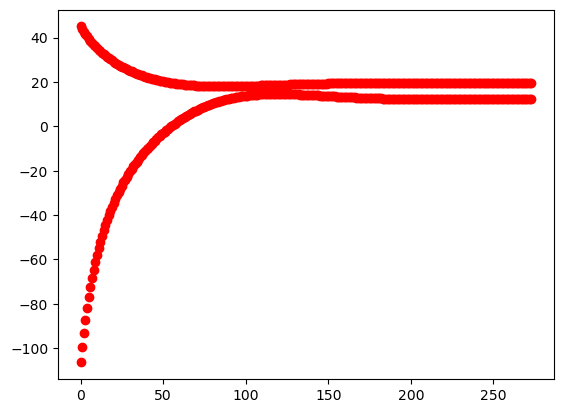

In [73]:
x0=T[0]
x0.shape
# Simulate the system forward in time using the SINDy model
sim_data = sindy.simulate(x0, t_sim)
plt.plot(sim_data,'ro')

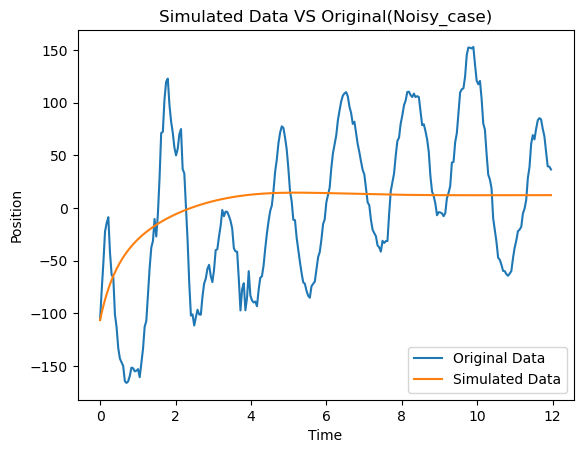

In [80]:
plt.plot(t_sim, T[:,0:1], label='Original Data')
plt.plot(t_sim, sim_data[:,0:1], label='Simulated Data')
plt.title("Simulated Data VS Original(Noisy_case)")
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.show()